ND

In [14]:
import numpy as np
import copy
import os
import yaml
yaml.Dumper.ignore_aliases = lambda *args : True
import utils
import matplotlib.pyplot as plt
import tqdm
import glob


import importlib
importlib.reload(utils)

<module 'utils' from '/n/home12/cfpark00/ML/ToyCompDiff/utils.py'>

In [15]:
def get_ntr_ntest(ns,n_per=128,method="fid_axis"):
    indsgrid=np.stack(np.meshgrid(*([np.arange(n) for n in ns]),indexing="ij"),axis=-1)
    if method=="fid_axis":
        n_nonzero=np.sum(indsgrid!=0,axis=-1)
        sel=(n_nonzero<=1).flatten().astype(int)
        ntr=(sel*n_per).tolist()
        ntest=((1-sel)*n_per).tolist()
    else:
        raise ValueError("Unknown method")
    return ntr,ntest

In [16]:
config={
    'experiment_directory': None,
    'seed': None,
    "dataset":"images_1",
    'n_samples_train':[],
    'n_samples_test':[],
    'n_samples_train_gen':[],
    'n_samples_test_gen':[],
    "data_params":{
        "n_classes":64,
        "image_size": 32,
        "noise_level": 0.001,
        "comp_dims":{"shape":None,"x":None,"y":None,"color":2,"size":2,"bg_color":2},
        
        #"shape":{"names":["circle","triangle"]},#will default to circle
        "x":{"min":-0.5,"max":0.5,"n":None,"s":0.05,"s_n":0.0},
        "y":{"min":-0.5,"max":0.5,"n":None,"s":0.05,"s_n":0.0},
        "color":{"means":[[0.9,0.1,0.1],[0.1,0.1,0.9]],"mins":[[0.8,0.0,0.0],[0.0,0.0,0.8]],"maxs":[[1.0,0.2,0.2],[0.2,0.2,1.0]],"s_n":0.0},
        "size":{"means":[0.6,0.2],"mins":[0.52,0.12],"maxs":[0.68,0.28],"s_n":0.00,"min":0.1},
        "bg_color":{"means":[[0.9,0.9,0.9],[0.1,0.1,0.1]],"mins":[[0.8,0.8,0.8],[0.0,0.0,0.0]],"maxs":[[1.0,1.0,1.0],[0.2,0.2,0.2]],"s_n":0.0},
    },
    "model_params":{
        "model_type": "VDiff",
        "optimizer_type": "AdamW",
        "optimizer_params": {"lr": 0.001,"weight_decay": 0.01},
        "data_noise":1e-3,
        "beta_settings": {"type":"logsnr","noise_schedule":"learned_linear","gamma_min":-5., "gamma_max":10.},
        "network_params": {"mid_attn":True,
                           "v_conditioning_type":"sep_mlp",
                           "v_conditioning_dims":[11],
                           "chs": [64,128,256],
                           "num_res_blocks":2,
                           "init_scale":1.0},
    },
    "batch_size": 64,
    "train_ratio": 0.85,
    'num_steps': 40_000,
    'save_steps_start': 50,
    'save_steps': 120,

    "fig_n_col": 4,
}

2x2x2

In [17]:
ntr,ntest=get_ntr_ntest([2,2,2],n_per=2048,method="fid_axis")
ntr_gen,ntest_gen=get_ntr_ntest([2,2,2],n_per=32,method="fid_axis")
np.sum(ntr),np.sum(ntest),np.sum(ntr_gen),np.sum(ntest_gen)

(8192, 8192, 128, 128)

In [18]:
#"bg_color":{"means":[[0.9,0.9,0.9],[0.1,0.1,0.1]],"mins":[[0.8,0.8,0.8],[0.0,0.0,0.0]],"maxs":[[1.0,1.0,1.0],[0.2,0.2,0.2]],"s_n":0.0}

In [26]:
def get_config(sep_col=0.8,sep_size=0.4,sep_bg_col=0.8,seed=0):
    assert sep_col<=0.8 and sep_size<=0.4 and sep_bg_col<=0.8
    config_=copy.deepcopy(config)
    config_["seed"]=seed

    config_["data_params"]["n_classes"]=8
    
    #bg color
    hsb=sep_bg_col/2
    config_["data_params"]["bg_color"]["means"]=[[0.5+hsb,0.5+hsb,0.5+hsb],[0.5-hsb,0.5-hsb,0.5-hsb]]
    s=sep_bg_col/8
    assert 0.5-hsb+s<0.5+hsb-s
    config_["data_params"]["bg_color"]["mins"]=[[0.5+hsb-s,0.5+hsb-s,0.5+hsb-s],[0.5-hsb-s,0.5-hsb-s,0.5-hsb-s]]
    config_["data_params"]["bg_color"]["maxs"]=[[0.5+hsb+s,0.5+hsb+s,0.5+hsb+s],[0.5-hsb+s,0.5-hsb+s,0.5-hsb+s]]
    #color
    hsc=sep_col/2
    config_["data_params"]["color"]["means"]=[[0.5+hsc,0.5-hsc,0.5-hsc],[0.5-hsc,0.5-hsc,0.5+hsc]]
    s=sep_col/8
    config_["data_params"]["color"]["mins"]=[[0.5+hsc-s,0.5-hsc-s,0.5-hsc-s],[0.5-hsc-s,0.5-hsc-s,0.5+hsc-s]]
    config_["data_params"]["color"]["maxs"]=[[0.5+hsc+s,0.5-hsc+s,0.5-hsc+s],[0.5-hsc+s,0.5-hsc+s,0.5+hsc+s]]
    #size
    hss=sep_size/2
    config_["data_params"]["size"]["means"]=[0.45+hss,0.45-hss]
    s=sep_size*3/8
    config_["data_params"]["size"]["mins"]=[0.45+hss-s,0.45-hss-s]
    config_["data_params"]["size"]["maxs"]=[0.45+hss+s,0.45-hss+s]
    return config_

In [12]:
configs_sc2ss2sb2=[]
for sep_col in [0.2,0.6]:
    for sep_size in [0.2,0.35]:
        for sep_bg_col in [0.2,0.6]:
            for seed in [0,100,200,300,400]:
                fol=f"images_1/2x2x2_final/sc2ss2sb2_re/sep_col={sep_col}_sep_size={sep_size}_sep_bg_col={sep_bg_col}"
                experiment_name=f"seed={seed}"
                config_=get_config(sep_col=sep_col,sep_size=sep_size,sep_bg_col=sep_bg_col,seed=seed)
                config_['n_samples_train']=ntr
                config_['n_samples_test']=ntest_gen #intentional
                config_['n_samples_train_gen']=ntr_gen
                config_['n_samples_test_gen']=ntest_gen
                config_["fig_n_col"]=4
                if (sep_col,sep_size,sep_bg_col)in [(0.6, 0.2, 0.6),(0.2, 0.2, 0.6),(0.2, 0.35, 0.2)]:
                    config_["save_ckpts"]=True
                else:
                    config_["save_ckpts"]=False
                config_=utils.process_config(config_,check_only=True)
                experiment_directory=os.path.join("data",fol,experiment_name)
                config_["experiment_directory"]=experiment_directory
                yaml_fol=os.path.join("yamls",fol)
                os.makedirs(yaml_fol,exist_ok=True)
                yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
                yaml.dump(config_,open(yaml_path,"w"))
                configs_sc2ss2sb2.append(config_)

In [13]:
yaml_files=glob.glob("./yamls/images_1/2x2x2_final/sc2ss2sb2_re/*/*.yaml")

n_proc=5
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2x2_final/sc2ss2sb2_re/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [27]:
configs_sc3ss1sb3=[]
for sep_col in [0.2,0.4,0.6]:
    for sep_size in [0.35]:
        for sep_bg_col in [0.1,0.2,0.3]:
            for seed in [0,100,200,300,400]:
                fol=f"images_1/2x2x2_final/sc3ss1sb3/sep_col={sep_col}_sep_size={sep_size}_sep_bg_col={sep_bg_col}"
                experiment_name=f"seed={seed}"
                config_=get_config(sep_col=sep_col,sep_size=sep_size,sep_bg_col=sep_bg_col,seed=seed)
                config_['n_samples_train']=ntr
                config_['n_samples_test']=ntest_gen #intentional
                config_['n_samples_train_gen']=ntr_gen
                config_['n_samples_test_gen']=ntest_gen
                config_["fig_n_col"]=4
                config_["save_ckpts"]=True
                config_=utils.process_config(config_,check_only=True)
                experiment_directory=os.path.join("data",fol,experiment_name)
                config_["experiment_directory"]=experiment_directory
                yaml_fol=os.path.join("yamls",fol)
                os.makedirs(yaml_fol,exist_ok=True)
                yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
                yaml.dump(config_,open(yaml_path,"w"))
                configs_sc3ss1sb3.append(config_)

In [28]:
yaml_files=glob.glob("./yamls/images_1/2x2x2_final/sc3ss1sb3/*/*.yaml")

n_proc=5
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2x2_final/sc3ss1sb3/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [15]:
config_=configs_sc2ss2sb2[3*5]
x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config_)

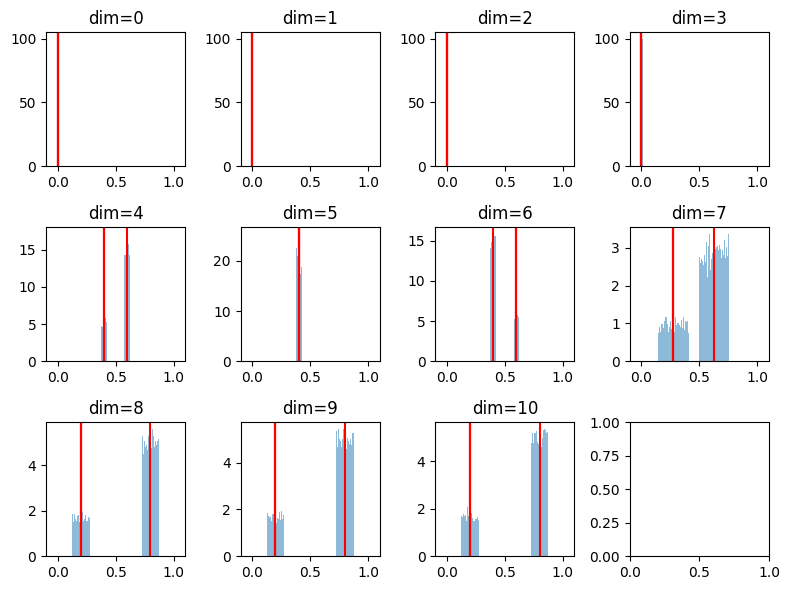

In [16]:
import matplotlib.pyplot as plt
import tqdm
fig,axs=plt.subplots(3,4,figsize=(8,6))
for dim in range(y_tr.shape[1]):
    ax=axs.flatten()[dim]
    l_te_unique=np.unique(l_te)
    y_tes=[y_te[l_te==l][0,dim] for l in l_te_unique]
    ax.hist(y_tr[:,dim],bins=100,density=True,alpha=0.5)
    for y in y_tes:
        ax.axvline(y,color="r")
    ax.set_title(f"dim={dim}")
    ax.set_xlim(-0.1,1.1)
plt.tight_layout()